In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
!pip install optuna
import optuna
import time

In [2]:
# Load in x_train, x_test, y_train, y_test
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

X_train = np.array([' '.join(inner_array) for inner_array in X_train])

# Vectorizer to convert text data into tfidf features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# Creates another vectorizer but with the vocabulary from the training data
test_vectorizer = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
X_test_tfidf = test_vectorizer.fit_transform(X_test)

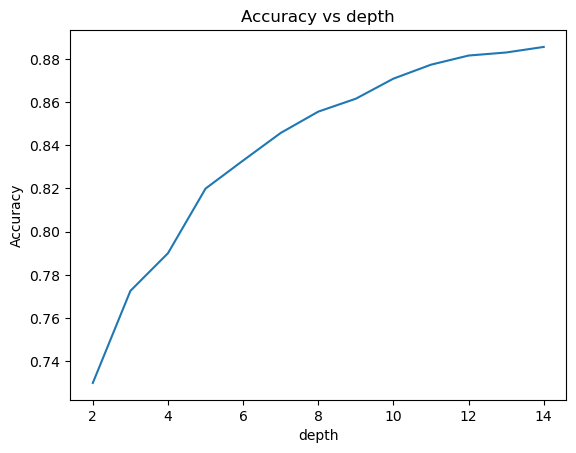

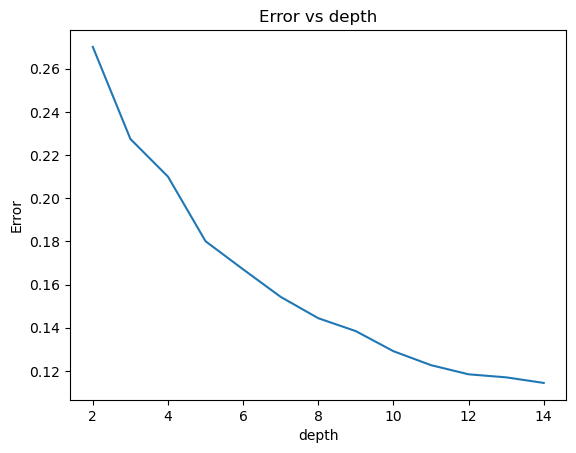

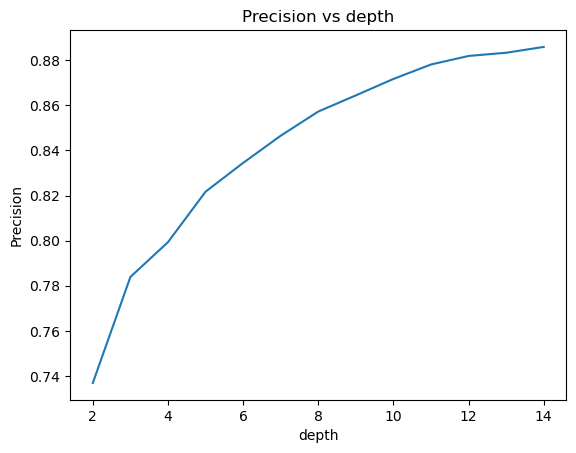

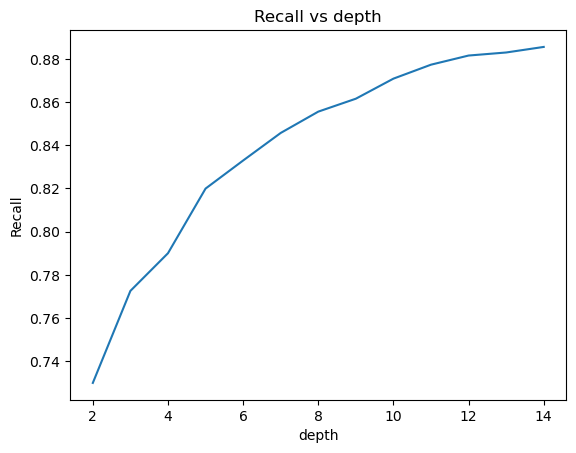

In [3]:
# Hyperparameter selection of max_depth in decision tree classifier

# Create empty lists to store the results
accuracy_vals = []
error_vals = []
precision_vals = []
recall_vals = []

# Max depths to try
depth = range(2, 15)

# Loop through each depth value
for num in depth:
    
    # Initialize decision tree  
    dtc = DecisionTreeClassifier(max_depth=num, criterion='entropy', random_state=42)
    
    # Cross-validation and compute accuracy
    acc_vals = cross_val_score(dtc, X_train_tfidf, y_train, cv=2, scoring='accuracy')
    
    # Store mean scores for each metric
    accuracy_vals.append(np.mean(acc_vals))
    error_vals.append(1 - np.mean(acc_vals)) 
    precision_vals.append(np.mean(cross_val_score(dtc, X_train_tfidf, y_train, cv=2, 
                                                  scoring='precision_macro')))
    recall_vals.append(np.mean(cross_val_score(dtc, X_train_tfidf, y_train, cv=2, 
                                               scoring='recall_macro')))
    
# Plot accuracy
plt.plot(depth, accuracy_vals, label='Accuracy')
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs depth')
plt.show()

# Plot error
plt.plot(depth, error_vals, label='Error')
plt.xlabel('depth')
plt.ylabel('Error')
plt.title('Error vs depth')
plt.show()

# Plot precision
plt.plot(depth, precision_vals, label='Precision')
plt.xlabel('depth')
plt.ylabel('Precision')
plt.title('Precision vs depth')
plt.show()

# Plot recall
plt.plot(depth, recall_vals, label='Recall')
plt.xlabel('depth')
plt.ylabel('Recall')
plt.title('Recall vs depth')
plt.show()

In [4]:
# Train and measure the time taken to train
start_time = time.time()

# Optimal to go with 10 given the graph above
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=42)

# Train decision tree
dtc.fit(X_train_tfidf, y_train)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

# Predict on training and testing data
test_preds = dtc.predict(X_test_tfidf)

Total time taken: 5.62 seconds


In [5]:
# Compute auc
auc = roc_auc_score(y_test, test_preds)

# Compute AUC using probabilities for positive class
y_pred_probs = dtc.predict_proba(X_test_tfidf)[:, 1]
auc = roc_auc_score(y_test, y_pred_probs)
print(auc)

# Print classification report
print(classification_report(y_test, test_preds))

0.9303004019598424
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      6143
         1.0       0.83      0.87      0.85      3602

    accuracy                           0.89      9745
   macro avg       0.88      0.88      0.88      9745
weighted avg       0.89      0.89      0.89      9745



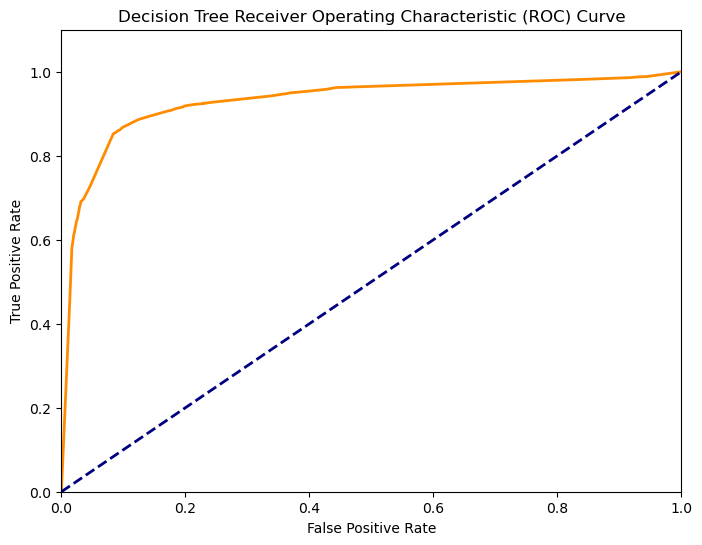

In [6]:
# Roc curve

# Optimal to go with 10 given the graph above
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=42)

# Train decision tree
dtc.fit(X_train_tfidf, y_train)

# Predict probabilities for the test set
probs = dtc.predict_proba(X_test_tfidf)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.10])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [7]:
# Plot a decision tree of max_depth 3 for easy visualization
dtc = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=42)

# Train decision tree
dtc.fit(X_train_tfidf, y_train)

# Predict on training and testing data
test_preds = dtc.predict(X_test_tfidf)

plt.gcf().set_size_inches(120, 80)
plot_tree(dtc, feature_names=test_vectorizer.get_feature_names_out(X_test_tfidf));